In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import os
env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

In [3]:
from lace.emulator_nn.network import MDNemulator_polyfit
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.test_simulation_nn import test_sim
from lace.emulator import pd_archive


/data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?


In [4]:
# our modules
from lace.emulator import gp_emulator
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d


In [5]:
def sigma68(data): return 0.5*(np.nanquantile(data,q = 0.84,axis = 0) - np.nanquantile(data,q = 0.16,axis = 0))


In [8]:
emuparams = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
initial_weights='initial_weights.pt'


## TEST OTHER COSMOLOGIES

In [13]:
#cosmos = ['central','h','nu','diffseed','P18', 'running', 'curved']
cosmos = ['central','diffseed','h','nu','running','curved','diffigm']


fractional_errors=np.zeros((len(cosmos), 11, 42))
emu_p1derrs=np.zeros((len(cosmos), 11, 42))
emu_p1ds = np.zeros((len(cosmos), 11, 42))
true_p1ds=np.zeros((len(cosmos), 11, 42))


emulator = NNEmulator(emuparams, zmax=4.5, Nsim=30, nepochs=0, step_size=75, postprocessing='768', list_archives=['data_input_axes','data_input_phases'],model_path='/nfs/pic.es/user/l/lcabayol/DESI/LaCE/lace/emulator/NNmodels/NNEmulator_LaCEHC.pt', drop_sim=None, kmax_Mpc= 4, ndeg=5)
for i,c in enumerate(cosmos):

    truth=pd_archive.archivePD(z_max=4.5,nsamples=30, pick_sim=c)
    truth.average_over_samples(flag="all")
    zs = [d['z'] for d in truth.data_av_all if d['scale_tau'] == 1] 
    truth = [d for d in truth.data_av_all if d['scale_tau'] == 1] 
    
    fractional_error, emu_p1d, true_p1d, emu_p1derr = test_sim(emulator.emulator, truth, emuparams, emulator.paramLims, emulator.device, emulator.yscalings,  kmax_Mpc_test=4, ndeg=5 )

    fractional_errors[i] = fractional_error
    emu_p1ds[i] = emu_p1d
    true_p1ds[i] = true_p1d
    emu_p1derrs[i] = emu_p1derr

start the training of the emulator
Training network on 11550
Emualtor trained in 4.5299530029296875e-06 seconds
42
Mean fractional error: 0.9996478710815823
Std fractional error: 0.004226631921874135
42
Mean fractional error: 0.9996166970696762
Std fractional error: 0.004683092549240499
42
Mean fractional error: 1.0001611573962257
Std fractional error: 0.004706399359556173
Sim has neutrinos
42
Mean fractional error: 0.9978515044825509
Std fractional error: 0.004438497038806846
42
Mean fractional error: 0.9949160414604473
Std fractional error: 0.007043669806308828
42
Mean fractional error: 0.9987795066924431
Std fractional error: 0.004331384493691618
42
Mean fractional error: 0.9852485744125943
Std fractional error: 0.019731973015084465


In [ ]:
import torch
initial_weights = emulator.emulator.state_dict()
torch.save(initial_weights,'/nfs/pic.es/user/l/lcabayol/DESI/LaCE/lace/emulator/NNmodels/NNEmulator_LaCEHC.pt')

In [14]:
# make pretty plots
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 22}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [15]:
fractional_errors = (fractional_errors -1)*100

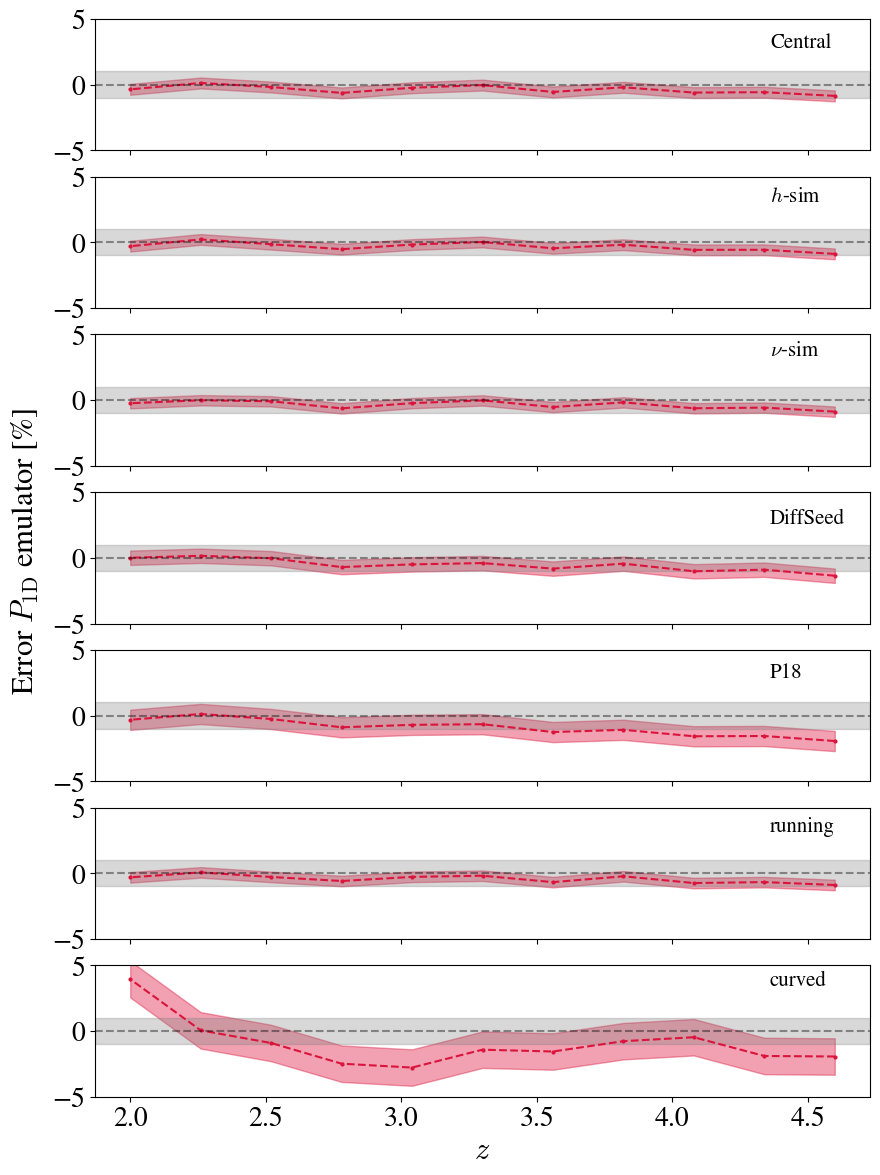

In [34]:
colors = ['crimson']
fig, ax = plt.subplots(ncols=1, nrows= len(cosmos),figsize = (10,2*len(cosmos)), sharey=True, sharex=True)
zaxis = np.flip(np.linspace(2.,4.6,11))

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15 )


for c in range(len(cosmos)):
    ax[c].plot(zaxis, np.nanmedian(fractional_errors[c],1), ls = '--', marker = 'o',markersize=2, color = colors[0])
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors[c],1) - sigma68(fractional_errors[c].flatten()),np.nanmedian(fractional_errors[c],1) + sigma68(fractional_errors[c].flatten()), color = colors[0], alpha = 0.4)

    
    ax[c].axhspan(-1,1,color="gray",alpha=0.3)
    ax[c].axhline(y=0,color="black",ls='--', alpha =0.4)


#ax[1].plot(zaxis, np.nanmedian(fractional_error_h,1), ls = '--', marker = 'o',markersize=2, color = 'crimson')
#ax[1].fill_between(zaxis, np.nanmedian(fractional_error_h,1) - sigma68(np.nanmedian(fractional_error_h,1)),np.nanmedian(fractional_error_h,1) + sigma68(np.nanmedian(fractional_error_h,1)), color = 'crimson', alpha = 0.4)


ax[0].set_ylim(-5,5)

#plt.ylabel(r'Percent error', fontsize = 14)

fig.text(0.04, 0.5, r'Error $P_{\rm 1D}$ emulator [%]', va='center', rotation='vertical')
fig.text(0.8, 0.86, r'Central',fontsize = 15)
fig.text(0.8, 0.75, r'$h$-sim',fontsize = 15)
fig.text(0.8, 0.64, r'$\nu$-sim',fontsize = 15)
fig.text(0.8, 0.52, r'DiffSeed',fontsize = 15)
fig.text(0.8, 0.41, r'P18',fontsize = 15)
fig.text(0.8, 0.3, r'running',fontsize = 15)
fig.text(0.8, 0.19, r'curved',fontsize = 15)
plt.xlabel(r"$z$")



plt.savefig('other_cosmologies.pdf', bbox_inches = 'tight')

### Gaussian Process

In [16]:
emu_type = 'polyfit'
training=pd_archive.archivePD(z_max=4.5,nsamples=30)
training.average_over_samples(flag="all")
training.average_over_samples(flag="phases")
training.average_over_samples(flag="axes")
training.input_emulator(flag="all")
training.input_emulator(flag="phases")
training.input_emulator(flag="axes")
training.data_av_all = [d for d in training.data_av_all if d['scale_tau'] == 1] 

In [17]:
kmax_Mpc=4
ndeg=5
sim_zs=[data['z'] for data in training.data]
Nz=len(sim_zs)
sim_k_Mpc=training.data[0]['k_Mpc']
Nk=len(sim_k_Mpc)
k_mask=(sim_k_Mpc<kmax_Mpc) & (sim_k_Mpc>0)
sim_k_Mpc=sim_k_Mpc[k_mask]
Nk=len(sim_k_Mpc)

emu_test=gp_emulator.GPEmulator(z_max=4.5,kmax_Mpc=kmax_Mpc,ndeg=ndeg,
                        train=True,asymmetric_kernel=True,rbf_only=True,
                        passarchive=training,emu_type=emu_type,check_hull=False, key_data='data_av_all')



 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 1.18 seconds


In [18]:
fractional_errors_gp=np.zeros((len(cosmos), 11, 42))
#cosmos = ['central','h','nu','diffseed','diffigm', 'running', 'curved']
cosmos = ['central','diffseed','h','nu','running','curved','diffigm']

for i,c in enumerate(cosmos):

    truth=pd_archive.archivePD(z_max=4.5, pick_sim=c)
    truth.average_over_samples(flag="all")
    truth = [d for d in truth.data_av_all if d['scale_tau'] == 1] 
    
    for aa,item in enumerate(truth):
        # figure out redshift for this entry
        z=item["z"]

        true_k=item["k_Mpc"]
        k_mask=(true_k<kmax_Mpc) & (true_k>0)
        true_p1d=item["p1d_Mpc"][k_mask]
        coeff_p1d = poly_p1d.PolyP1D(true_k[k_mask],true_p1d,kmin_Mpc=1.e-3,kmax_Mpc=kmax_Mpc,deg=ndeg).lnP_fit
        poly=np.poly1d(coeff_p1d)
        true_p1d_poly =np.exp(poly(np.log(true_k[k_mask])))

        # true p1d (some sims have an extra k bin, so we need to define mask again)
        true_k=item["k_Mpc"]
        k_mask=(true_k<kmax_Mpc) & (true_k>0)
        true_p1d=item["p1d_Mpc"][k_mask]
        assert len(true_p1d)==Nk


        #plt.loglog(true_k[k_mask],true_p1d, label = 'true')
        #plt.loglog(true_k[k_mask],true_p1d_poly, label = 'polyfit')
        #plt.legend()
        #plt.show()

        # for each entry, figure emulator parameter describing it (labels)
        emu_call={}
        for bb,param in enumerate(emu_test.paramList):
            emu_call[param]=item[param]

        # ask emulator to emulate P1D (and its uncertainty)
        emu_p1d,emu_err=emu_test.emulate_p1d_Mpc(emu_call,sim_k_Mpc,return_covar=True)
        fractional_errors_gp[i,aa] = emu_p1d/true_p1d_poly
    print(f'mean fractional error: {np.mean(fractional_errors_gp[i])}')
    print(f'std fractional error: {np.std(fractional_errors_gp[i])}')



3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requested k bins are higher than the training values.
3.9095375244672983
3.909537524467298
Warning! Your requ

In [19]:
fractional_errors_gp = (fractional_errors_gp-1)*100

In [20]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

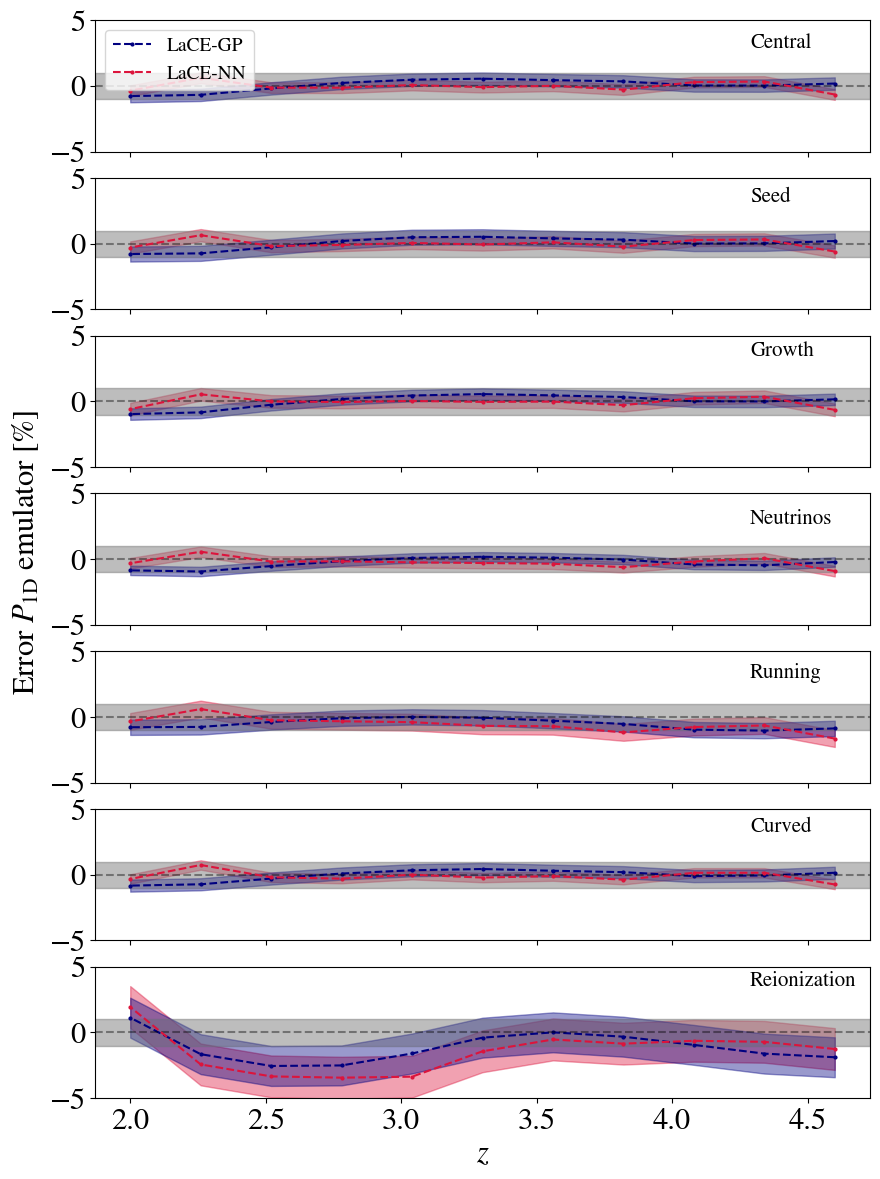

In [21]:
colors = ['crimson']
fig, ax = plt.subplots(ncols=1, nrows= len(cosmos),figsize = (10,2*len(cosmos)), sharey=True, sharex=True)
zaxis = np.flip(np.linspace(2.,4.6,11))

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20 )


for c in range(len(cosmos)):
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors[c],1) - sigma68(fractional_errors[c].flatten()),np.nanmedian(fractional_errors[c],1) + sigma68(fractional_errors[c].flatten()), color = 'crimson', alpha = 0.4)
    ax[c].axhspan(-1,1,color="gray",alpha=0.3)


    ax[c].plot(zaxis, np.nanmedian(fractional_errors_gp[c],1), ls = '--', marker = 'o',markersize=2, color = 'navy', label = 'LaCE-GP')
    ax[c].fill_between(zaxis, np.nanmedian(fractional_errors_gp[c],1) - sigma68(fractional_errors_gp[c].flatten()),np.nanmedian(fractional_errors_gp[c],1) + sigma68(fractional_errors_gp[c].flatten()), color = 'navy', alpha = 0.4)
    ax[c].axhspan(-1,1,color="gray",alpha=0.3)
    ax[c].axhline(y=0,color="black",ls='--', alpha =0.4)
    ax[c].plot(zaxis, np.nanmedian(fractional_errors[c],1), ls = '--', marker = 'o',markersize=2, color = 'crimson', label = 'LaCE-NN')

#ax[1].plot(zaxis, np.nanmedian(fractional_error_h,1), ls = '--', marker = 'o',markersize=2, color = 'crimson')
#ax[1].fill_between(zaxis, np.nanmedian(fractional_error_h,1) - sigma68(np.nanmedian(fractional_error_h,1)),np.nanmedian(fractional_error_h,1) + sigma68(np.nanmedian(fractional_error_h,1)), color = 'crimson', alpha = 0.4)


ax[0].set_ylim(-5,5)

#plt.ylabel(r'Percent error', fontsize = 14)


fig.text(0.04, 0.5, r'Error $P_{\rm 1D}$ emulator [%]', va='center', rotation='vertical')
fig.text(0.78, 0.86, r'Central',fontsize = 15)
fig.text(0.78, 0.75, r'Seed',fontsize = 15)
fig.text(0.78, 0.64, r'Growth',fontsize = 15)
fig.text(0.78, 0.52, r'Neutrinos',fontsize = 15)
fig.text(0.78, 0.41, r'Running',fontsize = 15)
fig.text(0.78, 0.3, r'Curved',fontsize = 15)
fig.text(0.78, 0.19, r'Reionization',fontsize = 15)
plt.xlabel(r"$z$")


ax[0].legend(fontsize = 14, loc = 2)

plt.savefig('other_cosmologies_comparison.pdf', bbox_inches = 'tight')

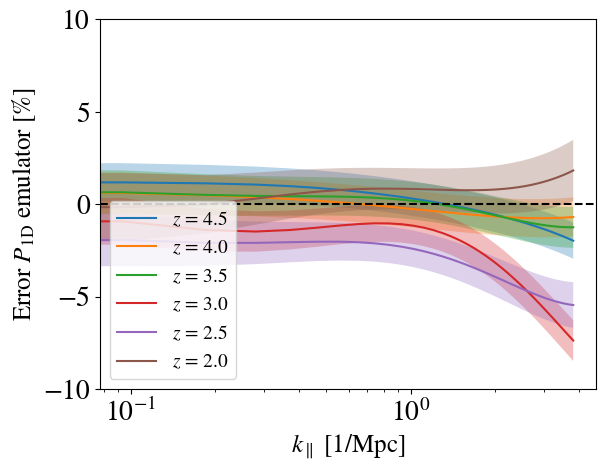

In [21]:
for i in np.arange(0,11,2):
#for i in range(0,1):

    plt.plot(emulator.k_Mpc[:42],fractional_errors[-1,i], label = f'$z$ = {zs[i]}')
    plt.fill_between(emulator.k_Mpc[:42],fractional_errors[-1,i]-emu_p1derrs[-1,i]/true_p1ds[-1,i]*100, fractional_errors[-1,i]+emu_p1derrs[-1,i]/true_p1ds[-1,i]*100 , alpha=0.3)

plt.ylim(-10,10)
#plt.fill_between(emulator.sim_k_Mpc[:85],-1,1, color='grey', alpha=0.2)
plt.legend(fontsize=14)
plt.ylabel(r'Error $P_{\rm 1D}$ emulator [%]', fontsize=18)
plt.xlabel(r'$k_{\parallel}$ [1/Mpc]', fontsize=18)
plt.xscale('log')

plt.axhline(y=0, ls ='--', color ='black')
plt.savefig('P18_k4.pdf',bbox_inches='tight')